In [132]:
import urllib
import pandas as pd 
from sunpy.time import TimeRange
from flarelist_utils import read_swpc_reports, read_ngdc_goes_reports
from dateutil.relativedelta import relativedelta
import pandas as pd 
import numpy as np
import datetime
import glob
import h5netcdf
import matplotlib.pyplot as plt
from scipy.io import readsav
import warnings
warnings.filterwarnings("ignore")

In [2]:
def print_flares(df):
    x = np.sum(df["goes_class_ind"].isin(["X"]))
    m = np.sum(df["goes_class_ind"].isin(["M"]))
    c = np.sum(df["goes_class_ind"].isin(["C"]))
    print("X: {:d}, M: {:d}, C: {:d}".format(x, m, c))

In [118]:
def get_yearly_swpc(year):
    year = datetime.datetime(year, 1, 1)
    filedir = "./goes_files/%Y_events/%Y*events*"
    all_files = []
    all_files += glob.glob(year.strftime(filedir))
    all_files.sort()
    df_flares = read_swpc_reports(all_files[0])
    for f in all_files[1:]:
        df = read_swpc_reports(f)
        df_flares = df_flares.append(df)
    df_flares.reset_index(inplace=True, drop=True)
    df_flares["ts"] = df_flares.date + df_flares.start_time
    df_flares.drop_duplicates(subset="ts")
    return df_flares[df_flares["goes_class_ind"].isin(["C", "X", "M"])]


def get_yearly_ngdc(year):
    year = datetime.datetime(year, 1, 1)
    file = "goes-xrs-report_%Y.txt"
    df = read_ngdc_goes_reports(year.strftime(file))
    df["ts"] = df.date + df.start_time
    df.drop_duplicates(subset="ts")
    return df[df["goes_class_ind"].isin(["X", "M", "C"])]

def get_yearly_ssw(year):
    tstart = datetime.datetime(year, 1, 1)
    tend = datetime.datetime(year, 12, 31)
    return ssw[(ssw["datetime"]>=tstart) & (ssw["datetime"]<=tend)]
    
def get_yearly_hek(year):
    tstart = datetime.datetime(year, 1, 1)
    tend = datetime.datetime(year, 12, 31)
    return hek_flares[(hek_flares["datetime"]>=tstart) & (hek_flares["datetime"]<=tend)]

In [119]:
ssw_flarelist = pd.read_csv("full_sswlatest.csv")
ssw = ssw_flarelist[ssw_flarelist["goes_class_ind"].isin(["X", "M", "C"])]
ssw["datetime"] = pd.to_datetime(ssw["time_start"])

In [120]:
len(ssw)

8773

In [121]:
print(ssw.datetime.min(), ssw.datetime.max())

2010-01-02 07:09:00 2018-03-30 07:57:00


## Lets look at HEK flares

In [122]:
hek_flares_all = pd.read_csv("solar_cycle24_flares.csv")
hek_flares_all.head(2)

,event_starttime,event_peaktime,event_endtime,fl_goescls,ar_noaanum
0,2009-07-05T07:07:00,2009-07-05T07:13:00,2009-07-05T07:18:00,C2.7,11024
1,2009-07-06T16:59:00,2009-07-06T17:05:00,2009-07-06T17:11:00,C1.0,11024


In [123]:
hek_flares_all["goes_class_ind"] = [x[0] for x in hek_flares_all["fl_goescls"]]
hek_flares_all["datetime"] = pd.to_datetime(hek_flares_all["event_starttime"])
hek_flares = hek_flares_all[hek_flares_all["goes_class_ind"].isin(["X", "M", "C"])]

In [124]:
hek_flares = hek_flares[(hek_flares.datetime>="2010-01-01")&(hek_flares.datetime<="2018-12-31")]

In [125]:
hek_flares.reset_index(drop=True, inplace=True)

In [126]:
hek_flares = hek_flares.drop_duplicates(subset="event_starttime")
len(hek_flares)

8619

In [127]:
len(hek_flares.drop_duplicates(subset="event_starttime"))

8619

In [128]:
print("SSW from helio:"); print_flares(ssw)
print("HEK:"); print_flares(hek_flares)

SSW from helio:
X: 49, M: 735, C: 7989
HEK:
X: 49, M: 756, C: 7814


In [130]:
def check_for_years(year):
    print(year)
    print_flares(get_yearly_hek(year))
    print_flares(get_yearly_ssw(year))
    print_flares(get_yearly_ngdc(year))
    print_flares(get_yearly_swpc(year))

In [131]:
for i in [2010, 2011, 2012, 2013, 2014, 2015, 2016]:
    check_for_years(i)

2010
X: 0, M: 23, C: 169
X: 0, M: 19, C: 161
X: 0, M: 23, C: 170
X: 0, M: 23, C: 170
2011
X: 8, M: 109, C: 1199
X: 8, M: 105, C: 1254
X: 8, M: 111, C: 1200
X: 8, M: 111, C: 1200
2012
X: 7, M: 129, C: 1336
X: 7, M: 112, C: 1216
X: 7, M: 123, C: 1259
X: 7, M: 129, C: 1337
2013
X: 12, M: 98, C: 1349
X: 12, M: 96, C: 1417
X: 12, M: 99, C: 1356
X: 12, M: 98, C: 1349
2014
X: 16, M: 209, C: 1785
X: 16, M: 210, C: 1906
X: 16, M: 205, C: 1797
X: 16, M: 207, C: 1793
2015
X: 2, M: 130, C: 1378
X: 2, M: 132, C: 1411
X: 2, M: 104, C: 1301
X: 2, M: 125, C: 1375
2016
X: 0, M: 16, C: 324
X: 0, M: 17, C: 343
X: 0, M: 16, C: 302
X: 0, M: 16, C: 321


## Lets look at the flares from the GOES IDL workbench

```
a = ogoes()
gev = a->get_gev('01-Jan-2010', '31-Dec-2018', /struct)
save, gev, filename="goes_flares_from_idl.sav"
```

In [138]:
gev_data = readsav("goes_flares_from_idl.sav")["gev"]

In [142]:
gev_dict = {k : gev_data[k].astype(str) for k in gev_data.dtype.names}
gev_df = pd.DataFrame(gev_dict)

In [144]:
gev_df["goes_class_ind"] = [x[0] for x in gev_df["CLASS"]]
gev_df["datetime"] = pd.to_datetime(gev_df["GSTART"])

In [148]:
gev_df_c = gev_df[gev_df["goes_class_ind"].isin(["C", "M", "X"])]
print(gev_df_c.datetime.min(), gev_df_c.datetime.max())

2010-01-02 07:09:00 2018-07-06 19:41:00


In [149]:
print("GEV sswidl:"); print_flares(gev_df_c)
print("SSW from helio:"); print_flares(ssw)
print("HEK:"); print_flares(hek_flares)

GEV sswidl:
X: 49, M: 740, C: 7736
SSW from helio:
X: 49, M: 735, C: 7989
HEK:
X: 49, M: 756, C: 7814


In [154]:
def ryan_test():
    gev_df = gev_df_c[(gev_df_c.datetime>"2010-05-01")&(gev_df_c.datetime<"2016-10-31")]
    sswy = ssw[(ssw.datetime>"2010-05-01")&(ssw.datetime<"2016-10-31")]
    print_flares(gev_df)
    print_flares(sswy)
ryan_test()

X: 45, M: 686, C: 7390
X: 45, M: 679, C: 7639


In [18]:
year = 2016
ssw_test = get_yearly_ssw(year)
ngdc_test = get_yearly_ngdc(year)
swpc_test = get_yearly_swpc(year)

In [19]:
ssw_test_m = ssw_test[ssw_test["goes_class_ind"].isin(["M"])]; ssw_test_m.reset_index(inplace=True, drop=True)
ngdc_test_m = ngdc_test[ngdc_test["goes_class_ind"].isin(["M"])]
swpc_test_m = swpc_test[swpc_test["goes_class_ind"].isin(["M"])]

In [20]:
ssw_test_m.iloc[8:12]

,time_start,time_end,time_peak,xray_class,lat_hg,long_hg,long_carr,nar,ename,url_nar,url_flare,goes_class_ind,goes_class_val,datetime
8,2016-07-23 01:40:00.0,2016-07-23 05:45:00.0,2016-07-23 05:16:00.0,M7.6,5,73,173.32,12565.0,gev_20160723_0140,http://www.solarmonitor.org/region.php?date=20...,http://www.lmsal.com/solarsoft/latest_events_a...,M,0.000076,2016-07-23 01:40:00
9,2016-07-23 01:46:00.0,2016-07-23 02:23:00.0,2016-07-23 02:11:00.0,M5.0,5,73,173.27,12567.0,gev_20160723_0146,http://www.solarmonitor.org/region.php?date=20...,http://www.lmsal.com/solarsoft/latest_events_a...,M,0.000050,2016-07-23 01:46:00
10,2016-07-23 05:00:00.0,2016-07-23 05:24:00.0,2016-07-23 05:16:00.0,M7.6,5,73,171.49,12567.0,gev_20160723_0500,http://www.solarmonitor.org/region.php?date=20...,http://www.lmsal.com/solarsoft/latest_events_a...,M,0.000076,2016-07-23 05:00:00
11,2016-07-23 05:27:00.0,2016-07-23 05:33:00.0,2016-07-23 05:31:00.0,M5.5,2,75,173.24,12565.0,gev_20160723_0527,http://www.solarmonitor.org/region.php?date=20...,http://www.lmsal.com/solarsoft/latest_events_a...,M,0.000055,2016-07-23 05:27:00


In [21]:
swpc_test_m.iloc[7:11]

,date,event_no,start_time,max_time,end_time,goes_sat,goes_channel,goes_class_ind,goes_class,integrated_flux,noaa_ar,ts
816,20160721,4680,0134,0149,0204,G15,1-8A,M,M1.0,1.2E-02,12567,201607210134
842,20160723,5430,0146,0211,0223,G15,1-8A,M,M5.0,5.4E-02,12567,201607230146
844,20160723,5450,0500,0516,0524,G15,1-8A,M,M7.6,4.6E-02,12567,201607230500
845,20160723,5470,0527,0531,0533,G15,1-8A,M,M5.5,1.1E-02,12567,201607230527


## Test new "reprocessed data"
https://satdat.ngdc.noaa.gov/sem/goes/data/science/xrs/goes14/xrsf-l2-flsum_science/
https://satdat.ngdc.noaa.gov/sem/goes/data/science/xrs/goes15/xrsf-l2-flsum_science/

Looks like these are the rescaled data so not what we need here

In [62]:
test = h5netcdf.File("sci_xrsf-l2-flsum_g15_s20100331_e20200304_v1-0-0.nc")

In [65]:
list(test.variables)

['xrsb_flux',
 'status',
 'time',
 'background_flux',
 'flare_class',
 'integrated_flux',
 'flare_counter']

In [66]:
np.array(test.variables["flare_counter"])

array([    1,     1,     2, ..., 20455, 20455, 20455], dtype=int32)

In [67]:
flare_class = np.array(test["flare_class"]).astype(str)

In [68]:
set(flare_class)

{'',
 'A9.3',
 'B0.9',
 'B1.0',
 'B1.1',
 'B1.2',
 'B1.3',
 'B1.4',
 'B1.5',
 'B1.6',
 'B1.7',
 'B1.8',
 'B1.9',
 'B2.0',
 'B2.1',
 'B2.2',
 'B2.3',
 'B2.4',
 'B2.5',
 'B2.6',
 'B2.7',
 'B2.8',
 'B2.9',
 'B3.0',
 'B3.1',
 'B3.2',
 'B3.3',
 'B3.4',
 'B3.5',
 'B3.6',
 'B3.7',
 'B3.8',
 'B3.9',
 'B4.0',
 'B4.1',
 'B4.2',
 'B4.3',
 'B4.4',
 'B4.5',
 'B4.6',
 'B4.7',
 'B4.8',
 'B4.9',
 'B5.0',
 'B5.1',
 'B5.2',
 'B5.3',
 'B5.4',
 'B5.5',
 'B5.6',
 'B5.7',
 'B5.8',
 'B5.9',
 'B6.0',
 'B6.1',
 'B6.2',
 'B6.3',
 'B6.4',
 'B6.5',
 'B6.6',
 'B6.7',
 'B6.8',
 'B6.9',
 'B7.0',
 'B7.1',
 'B7.2',
 'B7.3',
 'B7.4',
 'B7.5',
 'B7.6',
 'B7.7',
 'B7.8',
 'B7.9',
 'B8.0',
 'B8.1',
 'B8.2',
 'B8.3',
 'B8.4',
 'B8.5',
 'B8.6',
 'B8.7',
 'B8.8',
 'B8.9',
 'B9.0',
 'B9.1',
 'B9.2',
 'B9.3',
 'B9.4',
 'B9.5',
 'B9.6',
 'B9.7',
 'B9.8',
 'B9.9',
 'C0.9',
 'C1.0',
 'C1.1',
 'C1.2',
 'C1.3',
 'C1.4',
 'C1.5',
 'C1.6',
 'C1.7',
 'C1.8',
 'C1.9',
 'C2.0',
 'C2.1',
 'C2.2',
 'C2.3',
 'C2.4',
 'C2.5',
 'C2.6',
 'C2.

In [69]:
np.array(test["status"])

array([b'EVENT_START', b'EVENT_PEAK', b'EVENT_START', ..., b'EVENT_PEAK',
       b'EVENT_END', b'POST_EVENT'], dtype=object)

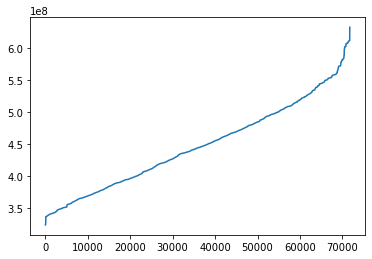

In [70]:
plt.plot(np.array(test["time"]))

## HEK testing sunpy

In [156]:
from sunpy.net import Fido, attrs as a


In [194]:
res = Fido.search(a.Time("2010-01-01", "2018-12-31"), 
                  a.hek.EventType("FL"), a.hek.FRM.Name=="SSW Latest Events")

In [195]:
res2 = res[0].to_pandas()

In [196]:
res2["frm_name"].unique()

array(['SSW Latest Events'], dtype=object)

In [197]:
res2["fl_goescls"].unique()

array(['B1.9', 'B2.3', 'B1.1', 'C1.0', 'B6.4', 'B4.5', 'B4.8', 'C2.6',
       'B4.3', 'C3.1', 'C2.0', 'B6.1', 'B1.5', 'B7.1', 'B1.3', 'B6.7',
       'B1.0', 'B3.3', 'C1.3', 'B1.4', 'B1.2', 'B1.7', 'B5.5', 'B5.6',
       'B2.1', 'B3.6', 'B2.5', 'B4.4', 'B3.7', 'B2.7', 'B3.9', 'B6.8',
       'B9.1', 'B5.4', 'C1.1', 'B3.0', 'B1.8', 'B2.2', 'B3.5', 'B4.2',
       'C2.1', 'B7.5', 'B8.5', 'C5.0', 'B5.8', 'B8.3', 'C5.2', 'C6.6',
       'C2.3', 'C5.1', 'C2.2', 'C4.0', 'C1.7', 'C3.9', 'C9.7', 'M1.0',
       'M1.6', 'M1.8', 'B9.2', 'B9.4', 'B6.9', 'M3.4', 'B6.6', 'B7.9',
       'C1.2', 'B2.6', 'B9.6', 'B2.4', 'B3.8', 'B2.0', 'B2.9', 'B3.2',
       'B4.6', 'B6.3', 'B6.2', 'B1.6', 'B3.4', 'B2.8', 'B9.0', 'C3.4',
       'M2.9', 'M1.3', 'C2.7', 'M6.4', 'C9.9', 'B7.4', 'C4.2', 'C1.4',
       'B7.0', 'B5.3', 'C6.2', 'C2.4', 'C7.7', 'C8.6', 'C6.8', 'C1.9',
       'M4.0', 'M1.1', 'C3.8', 'B7.7', 'B7.8', 'B8.6', 'B4.9', 'B8.4',
       'B6.5', 'C1.8', 'C1.5', 'C3.7', 'B9.5', 'C7.9', 'M8.3', 'B8.9',
      

In [198]:
res2["obs_instrument"].unique()

array(['EIT', 'SECCHI', 'SXI', 'AIA'], dtype=object)

In [201]:
list(res2["event_starttime"].unique())

['2010-01-01T12:02:00',
 '2010-01-01T12:33:00',
 '2010-01-01T23:29:00',
 '2010-01-02T03:10:00',
 '2010-01-02T07:09:00',
 '2010-01-02T07:58:00',
 '2010-01-02T09:01:00',
 '2010-01-02T11:59:00',
 '2010-01-02T14:08:00',
 '2010-01-02T22:39:00',
 '2010-01-02T22:57:00',
 '2010-01-03T01:17:00',
 '2010-01-03T03:53:00',
 '2010-01-03T07:43:00',
 '2010-01-03T10:50:00',
 '2010-01-03T12:01:00',
 '2010-01-03T14:43:00',
 '2010-01-03T15:29:00',
 '2010-01-03T15:52:00',
 '2010-01-03T18:59:00',
 '2010-01-03T20:43:00',
 '2010-01-04T03:36:00',
 '2010-01-04T10:00:00',
 '2010-01-04T14:24:00',
 '2010-01-04T19:51:00',
 '2010-01-04T20:14:00',
 '2010-01-05T08:46:00',
 '2010-01-05T09:53:00',
 '2010-01-06T02:57:00',
 '2010-01-06T16:40:00',
 '2010-01-06T19:44:00',
 '2010-01-06T19:45:00',
 '2010-01-07T21:23:00',
 '2010-01-08T17:42:00',
 '2010-01-09T06:06:00',
 '2010-01-09T07:46:00',
 '2010-01-09T08:40:00',
 '2010-01-09T11:07:00',
 '2010-01-09T12:41:00',
 '2010-01-09T14:50:00',
 '2010-01-09T22:23:00',
 '2010-01-09T22:

In [193]:
"SSW Latest Events"  in res

False

In [203]:
res["f"

gs_thumburl,comment_count,hpc_bbox,frm_humanflag,hgc_coord,event_coordsys,obs_levelnum,hpc_coord,event_npixels,gs_imageurl,ar_polarity,frm_paramset,hrc_coord,event_starttime,ar_mtwilsoncls,event_type,intensmin,fl_fluence,obs_meanwavel,frm_url,skel_chaincode,bound_chaincode,noposition,fl_fluenceunit,active,intensmax,frm_versionnumber,fl_peaktempunit,fl_halphaclass,area_uncert,obs_dataprepurl,hpc_geom,hgc_bbox,intensmedian,chaincodetype,obs_channelid,event_clippedspatial,ar_noaaclass,SOL_standard,event_avg_rating,eventtype,intensunit,hpc_boundcc,event_mapurl,frm_contact,ar_penumbracls,intensmean,bound_ccstartc1,frm_name,area_atdiskcenter,frm_identifier,obs_observatory,event_description,boundbox_c2ur,obs_firstprocessingdate,boundbox_c2ll,frm_institute,hrc_bbox,refs_orig,ar_mcintoshcls,event_maskurl,bound_ccstartc2,gs_movieurl,event_score,skel_startc2,skel_startc1,fl_efoldtime,event_expires,fl_efoldtimeunit,hrc_boundcc,event_probability,intensvar,frm_daterun,event_coordunit,hpc_y,hpc_x,search_instrument,ar_numspots,kb_archivdate,kb_archivist,intenstotal,sum_overlap_scores,hgs_boundcc,intensskew,obs_includesnrt,rasterscan,obs_wavelunit,kb_archivid,search_frm_name,boundbox_c1ur,ar_noaanum,area_atdiskcenteruncert,boundbox_c1ll,event_importance_num_ratings,ar_compactnesscls,skel_curvature,event_testflag,event_c2error,hrc_r,skel_nsteps,hgs_y,obs_title,fl_peakemunit,hgs_x,hcr_checked,frm_specificid,event_title,obs_instrument,event_c1error,revision,hpc_radius,event_endtime,event_importance,event_coord2,event_coord3,event_coord1,search_observatory,area_raw,concept,event_pixelunit,hgc_boundcc,fl_peakflux,hgc_x,hrc_a,event_peaktime,hgc_y,gs_galleryid,fl_goescls,hgs_coord,ar_zurichcls,bound_ccnsteps,intenskurt,event_clippedtemporal,fl_peakfluxunit,fl_peakem,rasterscantype,search_channelid,fl_peaktemp,hgs_bbox,area_unit,obs_lastprocessingdate,refs
str133,str1,str120,str5,str42,str12,object,str33,object,str132,object,str65,str41,str19,str1,str2,object,object,float64,str82,str1,str1,str5,str1,str4,object,object,str1,str1,object,str1,str186,str75,object,str1,str3,str1,str1,str30,object,str1,str1,str1,str1,str18,str1,object,object,str17,object,str9,str24,str1,int64,str1,int64,str5,str110,str1,str1,str1,object,str107,str21,object,object,object,str1,str1,str1,int64,object,str19,str7,float64,float64,str6,object,str19,str15,object,str23,str1,object,str1,str1,str2,str66,str17,int64,int64,object,int64,str1,str1,object,str5,int64,float64,object,float64,str1,str1,float64,str4,str1,str1,str6,int64,str3,str19,str19,object,int64,object,int64,str6,object,str5,str1,str1,object,float64,float64,str19,float64,str1,str4,str42,str1,object,object,str1,str1,object,str1,str19,object,str30,str1,str1,object
,0,"POLYGON((17.11086 69.4824,17.11086 69.4824,17.11086 69.4824,17.11086 69.4824,17.11086 69.4824))",false,POINT(57.283253 -29),UTC-HGS-TOPO,None,POINT(441.246 -434.9622),None,,None,"eitp_195_20100101_1157_1024.fits,eitp_195_20100101_1209_1024.fits",POINT(0.6454048880805 225.410894405118),2010-01-01T12:02:00,,FL,None,None,1.95e-06,http://sohowww.nascom.nasa.gov/solarsoft/packages/gevloc/idl/ssw_flare_locator.pro,,,false,,true,None,None,,,None,,010300000001000000050000000E2DB29DEF037A4061C3D32B65BF7CC00E2DB29DEF037A4061C3D32B659F79C00E2DB29DEF237D4061C3D32B659F79C00E2DB29DEF237D4061C3D32B65BF7CC00E2DB29DEF037A4061C3D32B65BF7CC0,,None,,EUV,,,SOL2010-01-01T12:02:00L057C119,None,9,,,,Samuel L. Freeland,,None,None,SSW Latest Events,None,SolarSoft,SoHO,,-28,,-30,LMSAL,"POLYGON((0.07454 346.165518,0.07454 346.165518,0.07454 346.165518,0.07454 346.165518,0.07454 346.165518))",,,,None,,0.238000000000000017,None,None,None,,,,1,None,2010-01-01T00:00:00,degrees,-434.9622,441.246,EIT,None,2010-01-01T14:12:01,freeland_samuel,None,3,,None,,,cm,ivo://helio-informatics.org/FL_SSWLatestEvents_20100101_061201_684,SSW Latest Events,32,1039,None,30,0,,None,false,0,0.6454048880805,None,-29.0,,,31.0,true,,,EIT,0,1,619.588692557280297,2010-01-01T12:18:00,None,-29,None,31,SOHO,None,Flare,,,

In [ ]:
def get_flares():
    """
    Query HEK for flares > C1 from past solar cycle and save results to csv.
    
    """
    event_type = "FL"
    tstart = "2010/01/01"
    tend = "2018/12/31"
    result = Fido.search(a.Time(tstart, tend),
                         a.hek.EventType(event_type),
                         a.hek.FRM.Name == "SWPC", 
                         a.hek.FL.GOESCls >= "C1.0")
    
    new_table = result["hek"]["event_starttime", "event_peaktime",
                             "event_endtime", "fl_goescls", "ar_noaanum", "frm_name",
                              "obs_observatory", "frm_institute", "search_frm_name"]
    new_table.write("solar_cycle24_flares.csv", format="csv")

In [204]:
event_type = "FL"
tstart = "2010/01/01"
tend = "2018/12/31"
result = Fido.search(a.Time(tstart, tend),
                     a.hek.EventType(event_type),
                     a.hek.FRM.Name == "SWPC", 
                     a.hek.FL.GOESCls >= "C1.0")

new_table = result["hek"]["event_starttime", "event_peaktime",
                         "event_endtime", "fl_goescls", "ar_noaanum", "frm_name",
                          "obs_observatory", "frm_institute", "search_frm_name"]
new_table.write("solar_cycle24_flares_swpc.csv", format="csv")

In [205]:
ls


1996_events/
2015_events/
20210101events.txt
20210105events.txt
__pycache__/
comparing_flare_lists.ipynb
events.txt
final_compare.ipynb
flarelist_utils.py
full_sswlatest.csv
get_flarelist.py
goes-xrs-report_2010.txt
goes-xrs-report_2011.txt
goes-xrs-report_2012.txt
goes-xrs-report_2013.txt
goes-xrs-report_2014.txt
goes-xrs-report_2015.txt
goes-xrs-report_2016.txt
goes_files/
goes_flares_from_idl.sav
goes_flares_from_idl.sav.textClipping
readme
sandbox_tests.ipynb
sci_xrsf-l2-flsum_g14_s20090901_e20200304_v1-0-0.nc
sci_xrsf-l2-flsum_g15_s20090901_e20200304_v1-0-0.nc
sci_xrsf-l2-flsum_g15_s20100331_e20200304_v1-0-0.nc
secchi_cmecat_combo.sav
solar_cycle24_flares.csv
solar_cycle24_flares_swpc.csv
ssw_flarelist_tests.ipynb
swpc_report_tests.py
testing_flarelists.ipynb
testy.png
testy2.png
